# Eval Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import json
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analysis import selection, workloads
from postgres import explain
from transform import db, mosp, ues

## 1. Broad applicability

In [40]:
def read_workload(path: str, workload: str, optimization: str, pg_ver: Any) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = selection.best_query_repetition(df, group_cols="label", performance_col="query_rt_total")
    df["workload"] = workload
    df["optimizer"] = optimization
    df["postgres_version"] = str(pg_ver)
    df.rename(columns={"query_rt_total": "execution_time"}, inplace=True)
    return df

In [41]:
job_ues_pg14 = read_workload("workloads/job-ues-results-base.csv", "JOB", "UES", 14)
job_ues_pg12 = read_workload("workloads/job-ues-results-base-pg12_4.csv", "JOB", "UES", 12.4)
job_nat_pg14 = read_workload("workloads/job-results-implicit-nonlj.csv", "JOB", "native", 14)
job_nat_pg12 = read_workload("workloads/job-results-implicit-pg12_4.csv", "JOB", "native", 12.4)

ssb_ues_pg14 = read_workload("workloads/ssb-ues-results-base.csv", "SSB", "UES", 14)
ssb_ues_pg12 = read_workload("workloads/ssb-ues-results-base-pg12_4.csv", "SSB", "UES", 12.4)
ssb_nat_pg14 = read_workload("workloads/ssb-results-implicit.csv", "SSB", "native", 14)
ssb_nat_pg12 = read_workload("workloads/ssb-results-implicit-pg12_4.csv", "SSB", "native", 12.4)

df = pd.concat([job_ues_pg14, job_ues_pg12, job_nat_pg14, job_nat_pg12, ssb_ues_pg14, ssb_ues_pg12, ssb_nat_pg14, ssb_nat_pg12])
df.groupby(["workload", "optimizer", "postgres_version"]).execution_time.sum()

workload  optimizer  postgres_version
JOB       UES        12.4                399.502253
                     14                  376.990205
          native     12.4                535.166116
                     14                  359.384317
SSB       UES        12.4                  5.545183
                     14                    5.311661
          native     12.4                  5.074911
                     14                    5.062522
Name: execution_time, dtype: float64

## Why is native better than UES @ JOB?

In [42]:
true_cards = pd.read_csv("workloads/job-results-true-cards.csv")[["label", "query_result"]].copy().rename(columns={"query_result": "cardinality"})

The native workload is ~17 seconds faster than the UES workload when using Postgres v14.2:

In [53]:
rt_cmp = pd.merge(job_ues_pg14[["label", "execution_time"]], job_nat_pg14[["label", "execution_time"]], on="label", suffixes=("_ues", "_native")).merge(true_cards, on="label")
rt_cmp["native_speedup"] = rt_cmp.execution_time_ues - rt_cmp.execution_time_native
rt_cmp.native_speedup.sum()

17.605888

This speedup is caused by only a handfull of queries, i.e. the 5% which have the largest speedup. These can be considered regressions.

In [54]:
rt_cmp[rt_cmp.native_speedup >= rt_cmp.native_speedup.quantile(0.95)]

,label,execution_time_ues,execution_time_native,cardinality,native_speedup
26,17b,7.674776,5.298563,78722.0,2.376213
27,17c,7.732492,4.343827,3323.0,3.388665
28,17d,7.726703,4.321574,15486.0,3.405129
30,17f,8.434191,5.593427,1664186.0,2.840764
31,18a,5.566490,4.100437,705.0,1.466053
104,7c,9.002675,4.842230,6668.0,4.160445


In [57]:
rt_cmp[rt_cmp.native_speedup <= rt_cmp.native_speedup.quantile(0.05)].native_speedup.sum()

-9.504779

## 2. Subquery evaluation

In [3]:
df_top20_lin = selection.best_query_repetition(pd.read_csv("workloads/topk-setups/job-ues-results-topk-20-approx-linear.csv"), group_cols="label", performance_col="query_rt_total")
df_top20_sq = selection.best_query_repetition(pd.read_csv("workloads/topk-setups/job-ues-results-topk-20-approx-smart.csv"), group_cols="label", performance_col="query_rt_total")

df_top20_lin.rename(columns={"query_result": "explain", "query_rt_total": "execution_time"}, inplace=True)
df_top20_sq.rename(columns={"query_result": "explain", "query_rt_total": "execution_time", "ues_final_bound": "upper_bound"}, inplace=True)
df_top20_lin["query"] = df_top20_lin["query"].apply(mosp.MospQuery.parse)
df_top20_sq["query"] = df_top20_sq["query"].apply(mosp.MospQuery.parse)
df_top20_lin["explain"] = df_top20_lin["explain"].apply(json.loads)
df_top20_sq["explain"] = df_top20_sq["explain"].apply(json.loads)
df_top20_lin["plan"] = df_top20_lin.apply(lambda res: explain.parse_explain_analyze(res["query"], res["explain"], with_subqueries=False), axis="columns")
df_top20_sq["plan"] = df_top20_sq.apply(lambda res: explain.parse_explain_analyze(res["query"], res["explain"], with_subqueries=True), axis="columns")
df_top20_lin["subqueries"] = "linear"
df_top20_sq["subqueries"] = "smart"


df_top20 = pd.merge(df_top20_sq[["label", "query", "upper_bound", "explain", "plan", "execution_time"]], df_top20_lin[["label", "query", "explain", "plan", "execution_time"]],
                    on="label", suffixes=("", "_linear"))
df_top20 = selection.reorder(df_top20)
df_top20.set_index("label", inplace=True)
df_top20["subquery_speedup"] = df_top20["execution_time_linear"] - df_top20["execution_time"]
df_top20.subquery_speedup.describe()

/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Hash
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Aggregate
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Gather
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Sort
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Gather Merge
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Materialize
  warnings.

count    113.000000
mean      -0.004298
std        0.219187
min       -0.553545
25%       -0.015100
50%       -0.001790
75%        0.005676
max        1.927231
Name: subquery_speedup, dtype: float64

In [4]:
q6c = df_top20.loc["6c"]
q6c

query                    SELECT COUNT(*) FROM movie_keyword AS mk JOIN ...
upper_bound                                                       44532735
explain                  [{'Plan': {'Node Type': 'Aggregate', 'Strategy...
plan                     Hash Join (ci.movie_id = t.id) <- [Hash Join (...
execution_time                                                    3.765851
query_linear             SELECT COUNT(*) FROM movie_keyword AS mk JOIN ...
explain_linear           [{'Plan': {'Node Type': 'Aggregate', 'Strategy...
plan_linear              Hash Join (n.id = ci.person_id) <- [Seq Scan :...
execution_time_linear                                             5.693082
subquery_speedup                                                  1.927231
Name: 6c, dtype: object

In [5]:
(q6c.execution_time_linear - q6c.execution_time) / q6c.execution_time_linear

0.3385215600267132

In [6]:
q6c.plan.pretty_print(include_exec_time=True)

Hash Join (ci.movie_id = t.id) (3.761s)
  <- Hash Join (ci.person_id = n.id) (3.245s)
    <- Seq Scan :: cast_info (1.472s)
    <- Seq Scan :: name (0.265s)
  <- Hash Join (t.id = mk.movie_id) (0.516s)
    <- Seq Scan :: title (0.155s)
    <- Hash Join (mk.keyword_id = k.id) (0.344s)
      <- Seq Scan :: movie_keyword (0.161s)
      <- Seq Scan :: keyword (0.006s)



In [7]:
q6c.plan_linear.pretty_print(include_exec_time=True)

Hash Join (n.id = ci.person_id) (5.688s)
  <- Seq Scan :: name (0.264s)
  <- Hash Join (ci.movie_id = t.id) (3.429s)
    <- Seq Scan :: cast_info (1.392s)
    <- Hash Join (t.id = mk.movie_id) (0.516s)
      <- Seq Scan :: title (0.154s)
      <- Hash Join (mk.keyword_id = k.id) (0.346s)
        <- Seq Scan :: movie_keyword (0.162s)
        <- Seq Scan :: keyword (0.006s)



In [16]:
q6c.plan.lookup_join("(ci.person_id = n.id)").inspect_node()

Hash Join
-------------------------------
  Join  : (ci.person_id = n.id)
  Filter: /
-------------------------------
  Incoming Rows (left) : 63475827
  Incoming Rows (right): 1
  Filtered Rows: /
  Outgoing Rows: 723
-------------------------------
  Execution Time: 3.244707 ms


In [18]:
q6c.plan_linear.lookup_join("(ci.movie_id = t.id)").inspect_node()

Hash Join
---------------------------------------
  Join  : (ci.movie_id = t.id)
  Filter: /
---------------------------------------
  Incoming Rows (left) : 63475827
  Incoming Rows (right): 11
  Filtered Rows: /
  Outgoing Rows: 1204
---------------------------------------
  Execution Time: 3.4291210000000003 ms


In [20]:
df_top20[df_top20.subquery_speedup == df_top20.subquery_speedup.min()]

,query,upper_bound,explain,plan,execution_time,query_linear,explain_linear,plan_linear,execution_time_linear,subquery_speedup
label,,,,,,,,,,
7a,SELECT COUNT(*) FROM person_info AS pi JOIN in...,2442255,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",Hash Join (ml.link_type_id = lt.id) <- [Hash J...,4.57078,SELECT COUNT(*) FROM person_info AS pi JOIN in...,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",Hash Join (ml.link_type_id = lt.id) <- [Hash J...,4.017235,-0.553545


In [22]:
q7a = df_top20.loc["7a"]
q7a.execution_time / q7a.execution_time_linear

1.1377925364087487

## 3. Tighter upper bound

*Plots are generated directly with R/ggplot*

## 4. Physical operator selection

In [23]:
df_base = selection.best_query_repetition(pd.read_csv("workloads/job-ues-results-base.csv"), group_cols="label", performance_col="query_rt_total")
df_idxnlj = selection.best_query_repetition(pd.read_csv("workloads/job-ues-results-idxnlj.csv"), group_cols="label", performance_col="query_rt_total")
df_base.rename(columns={"query_result": "explain", "query_rt_total": "execution_time"}, inplace=True)
df_idxnlj.rename(columns={"query_result": "explain", "query_rt_total": "execution_time"}, inplace=True)
df_job = pd.read_csv("workloads/job-workload-implicit.csv", converters={"query": mosp.MospQuery.parse}, index_col="label")

df_base.execution_time.sum(), df_idxnlj.execution_time.sum()

(376.990205, 383.32920999999993)

In [24]:
df_speedup = selection.reorder(pd.merge(df_base[["label", "query", "execution_time", "explain"]], df_idxnlj[["label", "execution_time", "explain"]],
                                        on="label", suffixes=("_base", "_idxnlj")))
df_speedup.set_index("label", inplace=True)
df_speedup["query"] = df_speedup["query"].apply(mosp.MospQuery.parse)
df_speedup["n_subqueries"] = df_speedup["query"].apply(lambda q: len(q.subqueries()))
df_speedup["idxnlj_speedup"] = df_speedup["execution_time_base"] - df_speedup["execution_time_idxnlj"]
df_speedup["explain_base"] = df_speedup["explain_base"].apply(json.loads)
df_speedup["explain_idxnlj"] = df_speedup["explain_idxnlj"].apply(json.loads)
df_speedup["plan_base"] = df_speedup.apply(lambda res: explain.parse_explain_analyze(res["query"], res["explain_base"], with_subqueries=False), axis="columns")
df_speedup["plan_idxnlj"] = df_speedup.apply(lambda res: explain.parse_explain_analyze(res["query"], res["explain_idxnlj"], with_subqueries=False), axis="columns")
df_speedup

/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Hash
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Aggregate
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Gather
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Sort
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Gather Merge
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/ues/postgres/explain.py:501: UserWarning: Unknown node type: Hash
  warnings.warn("U

,query,execution_time_base,explain_base,execution_time_idxnlj,explain_idxnlj,n_subqueries,idxnlj_speedup,plan_base,plan_idxnlj
label,,,,,,,,,
1a,SELECT COUNT(*) FROM movie_companies AS mc JOI...,0.973623,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.863367,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1,0.110256,Hash Join (mi_idx.movie_id = t.id) <- [Hash Jo...,Hash Join (t.id = mi_idx.movie_id) <- [Hash Jo...
1b,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,0.552701,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.551758,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0,0.000943,Hash Join (mc.company_type_id = ct.id) <- [Has...,Hash Join (mc.company_type_id = ct.id) <- [Has...
1c,SELECT COUNT(*) FROM movie_companies AS mc JOI...,0.688356,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.593068,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1,0.095288,Hash Join (mi_idx.movie_id = t.id) <- [Hash Jo...,Hash Join (t.id = mi_idx.movie_id) <- [Hash Jo...
1d,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,0.611675,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.609230,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0,0.002445,Hash Join (mc.company_type_id = ct.id) <- [Has...,Hash Join (mc.company_type_id = ct.id) <- [Has...
2a,SELECT COUNT(*) FROM movie_keyword AS mk JOIN ...,1.046022,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1.095424,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0,-0.049402,Hash Join (mc.company_id = cn.id) <- [Hash Joi...,Hash Join (mc.company_id = cn.id) <- [Hash Joi...
...,...,...,...,...,...,...,...,...,...
32a,SELECT COUNT(*) FROM movie_link AS ml JOIN lin...,0.010616,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.012412,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0,-0.001796,Hash Join (mk.keyword_id = k.id) <- [~Merge Jo...,Hash Join (mk.keyword_id = k.id) <- [~Merge Jo...
32b,SELECT COUNT(*) FROM movie_link AS ml JOIN lin...,0.429058,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.461229,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0,-0.032171,Hash Join (mk.keyword_id = k.id) <- [Merge Joi...,Hash Join (mk.keyword_id = k.id) <- [Merge Joi...
33a,SELECT COUNT(*) FROM movie_link AS ml JOIN lin...,1.619257,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1.798837,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",2,-0.179580,Hash Join (cn1.id = mc1.company_id) <- [~Seq S...,Hash Join (cn1.id = mc1.company_id) <- [~Seq S...


In [25]:
df_speedup.idxnlj_speedup.describe()

count    113.000000
mean      -0.056097
std        0.623122
min       -2.225481
25%       -0.179580
50%       -0.011038
75%        0.205862
max        3.100859
Name: idxnlj_speedup, dtype: float64

In [87]:
df_speedup[df_speedup.idxnlj_speedup == df_speedup.idxnlj_speedup.max()]

,query,execution_time_base,execution_time_idxnlj,explain,n_subqueries,idxnlj_speedup,plan
label,,,,,,,
8d,SELECT COUNT(*) FROM aka_name AS an1 JOIN name...,5.662634,2.561775,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1,3.100859,Hash Join (mc.company_id = cn.id) <- [Hash Joi...


In [91]:
q8d = df_speedup.loc["8d"]
q8d.plan_base.pretty_print(include_exec_time=True)

Hash Join (mc.company_id = cn.id) (5.520s)
  <- Hash Join (mc.movie_id = ci.movie_id) (5.435s)
    <- Seq Scan :: movie_companies (0.163s)
    <- Hash Join (ci.person_id = an1.person_id) (4.850s)
      <- Hash Join (ci.movie_id = t.id) (3.844s)
        <- Hash Join (ci.role_id = rt.id) (3.288s)
          <- Seq Scan :: cast_info (1.472s)
          <- Seq Scan :: role_type (0.000s)
        <- Seq Scan :: title (0.169s)
      <- Hash Join (an1.person_id = n1.id) (0.861s)
        <- Seq Scan :: aka_name (0.047s)
        <- Seq Scan :: name (0.225s)
  <- Seq Scan :: company_name (0.015s)



In [92]:
q8d.plan_idxnlj.pretty_print(include_exec_time=True)

Hash Join (mc.company_id = cn.id) (2.445s)
  <- Hash Join (mc.movie_id = ci.movie_id) (2.358s)
    <- Seq Scan :: movie_companies (0.168s)
    <- Hash Join (ci.person_id = an1.person_id) (1.764s)
      <- Hash Join (t.id = ci.movie_id) (0.746s)
        <- Seq Scan :: title (0.174s)
        <- Nested Loop (ci.role_id = rt.id) (0.124s)
          <- Seq Scan :: role_type (0.000s)
          <- Index Scan :: cast_info (0.080s)
      <- Hash Join (an1.person_id = n1.id) (0.869s)
        <- Seq Scan :: aka_name (0.047s)
        <- Seq Scan :: name (0.224s)
  <- Seq Scan :: company_name (0.015s)



In [109]:
q8d.plan_idxnlj.join_path()

'role_type rt ⋈ cast_info ci ⋈ title t ⋈ aka_name an1 ⋈ name n1 ⋈ movie_companies mc ⋈ company_name cn'

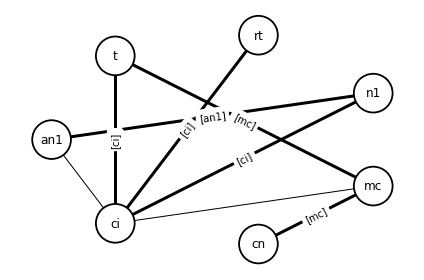

In [108]:
join_graph = ues.JoinGraph.build_for(df_job.loc["8d"].query)
join_graph.print()

In [111]:
q8d.execution_time_idxnlj / q8d.execution_time_base

0.4523998902277633

## Optimization prints

In [3]:
job = workloads.job()
q8d = job["8d"]
q8d

SELECT COUNT(*) FROM aka_name AS an1, cast_info AS ci, company_name AS cn, movie_companies AS mc, name AS n1, role_type AS rt, title AS t WHERE cn.country_code = '[us]' AND rt.role = 'costume designer' AND an1.person_id = n1.id AND n1.id = ci.person_id AND ci.movie_id = t.id AND t.id = mc.movie_id AND mc.company_id = cn.id AND ci.role_id = rt.id AND an1.person_id = ci.person_id AND ci.movie_id = mc.movie_id

SELECT COUNT(*) FROM aka_name AS an1 JOIN name AS n1 ON an1.person_id = n1.id JOIN (SELECT t.id AS t_id, rt.id AS rt_id, ci.person_id AS ci_person_id, ci.role_id AS ci_role_id, ci.movie_id AS ci_movie_id FROM cast_info AS ci JOIN role_type AS rt ON ci.role_id = rt.id AND rt.role = 'costume designer' JOIN title AS t ON ci.movie_id = t.id) AS ci_rt_t ON n1.id = ci_rt_t.ci_person_id AND an1.person_id = ci_rt_t.ci_person_id JOIN movie_companies AS mc ON ci_rt_t.t_id = mc.movie_id AND ci_rt_t.ci_movie_id = mc.movie_id JOIN company_name AS cn ON mc.company_id = cn.id AND cn.country_code = '[us]'

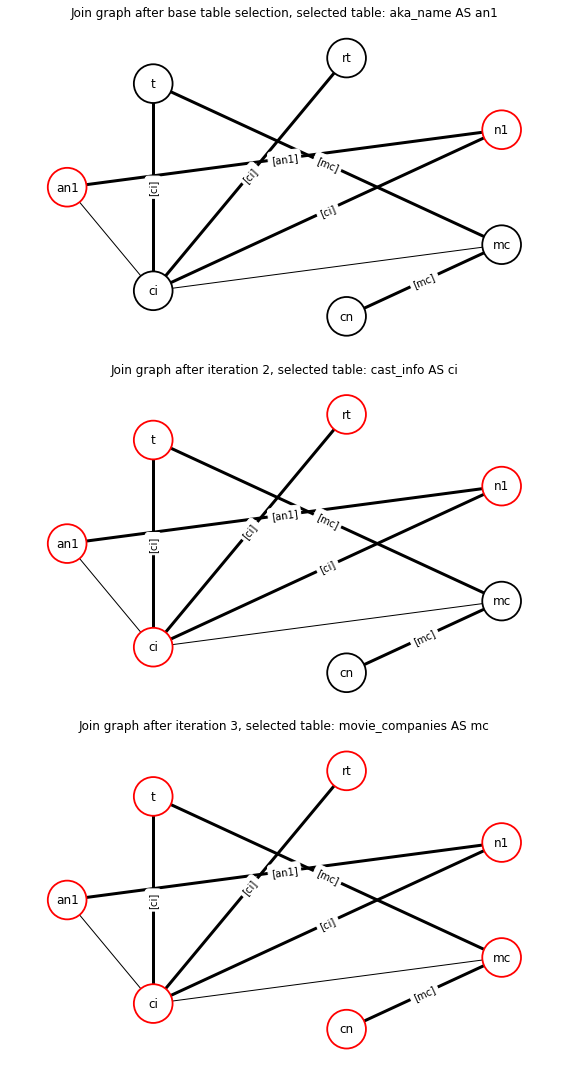

In [12]:
res = ues.optimize_query(q8d, visualize=True)
plt.savefig("join-graph.svg", bbox_inches="tight")
res

In [14]:
ues.optimize_query(q8d, trace=True)

Input query: SELECT COUNT(*) FROM aka_name AS an1, cast_info AS ci, company_name AS cn, movie_companies AS mc, name AS n1, role_type AS rt, title AS t WHERE cn.country_code = '[us]' AND rt.role = 'costume designer' AND an1.person_id = n1.id AND n1.id = ci.person_id AND ci.movie_id = t.id AND t.id = mc.movie_id AND mc.company_id = cn.id AND ci.role_id = rt.id AND an1.person_id = ci.person_id AND ci.movie_id = mc.movie_id
.. Bounds for candidate aka_name AS an1 :: Filter: 1312273 | PKs: [542277900]
.. Bounds for candidate cast_info AS ci :: Filter: 63475827 | PKs: [95498328060, 8250310588, 20490752]
.. Bounds for candidate movie_companies AS mc :: Filter: 4958296 | PKs: [9976844618, 715153214]
Selected first table: aka_name AS an1 with PK/FK joins [name AS n1]
.. Adding PK join with name AS n1 on an1.person_id = n1.id
.. Base estimates: {aka_name AS an1: 1312273, cast_info AS ci: 63475827, company_name AS cn: 138679, movie_companies AS mc: 4958296, name AS n1: 6379740, role_type AS rt: 1

SELECT COUNT(*) FROM aka_name AS an1 JOIN name AS n1 ON an1.person_id = n1.id JOIN (SELECT t.id AS t_id, rt.id AS rt_id, ci.person_id AS ci_person_id, ci.role_id AS ci_role_id, ci.movie_id AS ci_movie_id FROM cast_info AS ci JOIN role_type AS rt ON ci.role_id = rt.id AND rt.role = 'costume designer' JOIN title AS t ON ci.movie_id = t.id) AS ci_rt_t ON n1.id = ci_rt_t.ci_person_id AND an1.person_id = ci_rt_t.ci_person_id JOIN movie_companies AS mc ON ci_rt_t.t_id = mc.movie_id AND ci_rt_t.ci_movie_id = mc.movie_id JOIN company_name AS cn ON mc.company_id = cn.id AND cn.country_code = '[us]'